# Proyecto de Minería

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
shazam_df = pd.read_csv("data/ShazamData.csv", encoding = "ISO-8859-1")
spotify_df = pd.read_csv("data/spotifyData.csv", encoding = "ISO-8859-1")
tiktok_df = pd.read_csv("data/tiktokData.csv", encoding = "ISO-8859-1")


In [3]:
pattern = r'\s*(\(|\[).*?(Slowed|Reverb|sped up|Speed|Radio Edit|remix|Lofi|Remix|Mix|VHS|remastered|SLOWED|SUPER SLOWED|Sped Up|slowed|reverb).*?(\)|\])\s*'
shazam_df['trackName'] = shazam_df['trackName'].str.replace(pattern, '', regex=True)
shazam_df
print(shazam_df.iloc[424])

musicId      7323282980226140960
trackName                 EEYUH!
artists             H.R. & Irokz
Name: 424, dtype: object


### Agrupar canciones por día en spotifyData.csv

In [4]:
spotify_df["date"] = spotify_df["date"].str[:10]
grouped_by_day = spotify_df.groupby("date")
daily_data_df = pd.DataFrame()

In [5]:
import plotly.express as px

# Ordena el dataframe por 'date' y 'position'
spotify_df.sort_values(['date', 'position'], inplace=True)

# Selecciona los 5 tracks más populares de cada día
df_populares = spotify_df.groupby('date').head(5)

# Obtiene los nombres de los tracks más populares
tracks_populares = df_populares['trackName'].unique()

# Filtra el dataframe original para incluir solo los tracks más populares
df_filtrado = spotify_df[spotify_df['trackName'].isin(tracks_populares)]

# Crea el gráfico de líneas
fig = px.line(df_filtrado, x='date', y='position', color='trackName', title='Evolución temporal de la posición en la lista')

# Invierte el eje y para que la posición 1 aparezca en la parte superior
fig.update_yaxes(autorange="reversed")

fig.show()

fig = px.line(spotify_df, x='date', y='position', color='trackName', title='Evolución temporal de la posición en la lista')

# Invierte el eje y para que la posición 1 aparezca en la parte superior
fig.update_yaxes(autorange="reversed")

fig.update_layout(height=800)

fig.show()

In [6]:
shazam_df_fixed = shazam_df.drop_duplicates()
tiktok_df_fixed = tiktok_df.drop_duplicates()

tiktokshazam_df = pd.merge(tiktok_df_fixed, shazam_df_fixed, on='musicId', how='inner')

print(tiktokshazam_df)

      position                                              title  \
0            1  Get it Sexxxyyyyyy. Get your fav shade of tins...   
1            2  zawg and shlawg lookin spiffyð£ï¸ð£ï¸ð...   
2            3                           #funny #fyp #funnyclips    
3            4                                                NaN   
4            6                 hes so cuteð­ #jungwon #enhypen    
...        ...                                                ...   
3196       135  Win the Pacific! Grenade out! Send it! â¢ â¢...   
3197       136                            Cheeseburger Egg Rolls    
3198       137  Cool Kids Vs Cool Teachers Dance Battle!  - #S...   
3199       146  Dadcoreð¥¹â¤ï¸ >>> 3 #positivity #hopecore ...   
3200       148                                                NaN   

                       id                user      views     likes  comments  \
0     7351210572395941166           .melimuah    6100000    968400      2374   
1     73439

In [7]:
grouped_by_date_song = tiktokshazam_df.groupby(['date', 'trackName']).agg({'views': 'sum'})
grouped_by_date_song.reset_index(inplace=True)

fig = px.line(grouped_by_date_song, x='date', y='views', color='trackName', markers=True, title='Suma de views por canción en TikTok')

fig.update_layout(height=800)

fig.show()

In [8]:
spotifytiktok_df = pd.merge(tiktokshazam_df, spotify_df, on=['trackName','date'], how='inner')
spotifytiktok_df.head(10)

grouped_by_date_song = spotifytiktok_df.groupby(['date', 'trackName']).agg({'views': 'sum'})
grouped_by_date_song.reset_index(inplace=True)

fig = px.line(grouped_by_date_song, x='date', y='views', color='trackName', markers=True, title='Suma de views por canción en TikTok')

fig.update_layout(height=800)

fig.show()

El siguiente codigo crea un gráfico de dispersión para visualizar la relación entre las vistas en TikTok y las posiciones en Spotify.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión
fig = px.scatter(
    spotifytiktok_df,
    x='views',
    y='position_y',
    color='trackName',
    symbol='trackName',
    title='Relación entre Vistas en TikTok y Posición en Spotify',
    labels={
        'views': 'Vistas en TikTok',
        'position_y': 'Posición en Spotify'
    },
    template='plotly_white'
)

# Ajustar la leyenda
fig.update_layout(
    legend_title_text='Canción',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05,
        title_font=dict(size=10),
        font=dict(size=9)
    )
)

# Invertir el eje Y para que la posición 1 esté en la parte superior
fig.update_yaxes(autorange="reversed")

# Mostrar el gráfico
fig.show()

In [10]:
# Convertir la columna 'date' a datetime en el dataframe fusionado
spotifytiktok_df['date'] = pd.to_datetime(spotifytiktok_df['date'])

# Agrupar por canción y calcular vistas y likes totales por canción en TikTok
song_impact_tiktok = spotifytiktok_df.groupby('trackName').agg({'views': 'sum', 'likes': 'sum'}).reset_index()

# Renombrar columnas para mayor claridad
song_impact_tiktok.rename(columns={'trackName': 'Canción', 'views': 'Vistas en TikTok', 'likes': 'Likes en TikTok'}, inplace=True)

# Calcular la posición promedio por canción en Spotify
song_impact_spotify = spotifytiktok_df.groupby('trackName').agg({'position_y': 'mean'}).reset_index()

# Renombrar columnas para mayor claridad
song_impact_spotify.rename(columns={'trackName': 'Canción', 'position_y': 'Posición Promedio en Spotify'}, inplace=True)

# Fusionar los datasets de impacto en TikTok y posiciones en Spotify
combined_df = pd.merge(song_impact_tiktok, song_impact_spotify, on='Canción')

# Crear el gráfico de dispersión con vistas en el eje X y likes en el tamaño de los puntos
fig = px.scatter(
    combined_df,
    x='Vistas en TikTok',
    y='Posición Promedio en Spotify',
    size='Likes en TikTok',
    color='Canción',
    title='Relación entre Vistas en TikTok y Posición en Spotify',
    labels={'Vistas en TikTok': 'Vistas en TikTok', 'Posición Promedio en Spotify': 'Posición en Spotify'},
    template='plotly_white',
    hover_data={'Likes en TikTok': True}  # Agregar likes en el hover
)

# Invertir el eje Y para que la posición 1 esté en la parte superior
fig.update_yaxes(autorange="reversed")

# Ajustar las etiquetas del eje X a millones
fig.update_xaxes(tickvals=[0, 200_000_000, 400_000_000, 600_000_000, 800_000_000, 1_000_000_000],
                 ticktext=['0M', '200M', '400M', '600M', '800M', '1000M'])

# Mostrar el gráfico
fig.show()

El siguiente codigo crea un  gráfico que muestra cómo la popularidad en TikTok afecta las posiciones en Spotify en los días siguientes. Esto puede ayudar a entender el impacto a largo plazo de TikTok en Spotify.

In [11]:

# Crear el gráfico de líneas para tendencias a largo plazo
fig = px.line(
    spotifytiktok_df,
    x='date',
    y='position_y',
    color='trackName',
    title='Tendencias a Largo Plazo',
    labels={'date': 'Fecha', 'position_y': 'Posición en Spotify'}
)

fig.update_yaxes(autorange="reversed")
fig.show()

Los siguientes gráfico se generan con el fin de identificar los usuarios de TikTok más influyentes y analizar cómo sus videos afectan la popularidad de las canciones en Spotify.

In [12]:
# Agrupar por usuario y calcular la suma de vistas y likes
influencer_impact = tiktok_df.groupby('user').agg({'views': 'sum', 'likes': 'sum'}).reset_index()

# Ordenar por vistas y seleccionar los 20 principales influencers
top_influencers = influencer_impact.sort_values(by='views', ascending=False).head(20)

# Crear el gráfico de barras
fig = px.bar(
    top_influencers,
    x='user',
    y='views',
    color='likes',
    title='Impacto de Influencers',
    text='views',  # Agregar etiquetas de texto a las barras
    labels={'views': 'Vistas', 'user': 'Usuario', 'likes': 'Me gusta'}
)

# Ajustar la orientación de las etiquetas de los ejes
fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    width=1000
)

# Mostrar el gráfico
fig.show()

In [13]:
# Convertir la columna 'date' a datetime en el dataframe fusionado
spotifytiktok_df['date'] = pd.to_datetime(spotifytiktok_df['date'])

# Agrupar por canción y calcular vistas y likes totales por canción en TikTok
song_impact_tiktok = spotifytiktok_df.groupby('trackName').agg({'views': 'sum', 'likes': 'sum'}).reset_index()

# Renombrar columnas para mayor claridad
song_impact_tiktok.rename(columns={'trackName': 'Canción', 'views': 'Vistas en TikTok', 'likes': 'Likes en TikTok'}, inplace=True)

# Calcular la posición promedio por canción en Spotify
song_impact_spotify = spotifytiktok_df.groupby('trackName').agg({'position_y': 'mean'}).reset_index()

# Renombrar columnas para mayor claridad
song_impact_spotify.rename(columns={'trackName': 'Canción', 'position_y': 'Posición Promedio en Spotify'}, inplace=True)

# Fusionar los datasets de impacto en TikTok y posiciones en Spotify
combined_df = pd.merge(song_impact_tiktok, song_impact_spotify, on='Canción')

# Crear el gráfico de dispersión con likes en el eje X y vistas en el tamaño de los puntos
fig = px.scatter(
    combined_df,
    x='Likes en TikTok',
    y='Posición Promedio en Spotify',
    size='Vistas en TikTok',
    color='Canción',
    title='Relación entre Likes en TikTok y Posición en Spotify',
    labels={'Likes en TikTok': 'Likes en TikTok', 'Posición Promedio en Spotify': 'Posición en Spotify'},
    template='plotly_white',
    hover_data={'Vistas en TikTok': True}  # Agregar vistas en el hover
)

# Invertir el eje Y para que la posición 1 esté en la parte superior
fig.update_yaxes(autorange="reversed")

# Mostrar el gráfico
fig.show()

Los siguientes codigos son con el objetivo de utilizar modelos de aprendizaje automático para predecir las posiciones en Spotify basándose en las métricas de TikTok. Para ello vamos a utilizar distintos modelos (La mayoria vista en clases para realizar esta prediccion) estos modelos son Regresion lineal, KNeighbors,DecisionTree y RandomForest

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

# Seleccionar características y etiquetas
X = spotifytiktok_df[['views', 'likes']]
y = spotifytiktok_df['position_y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_linear = linear_model.predict(X_test)

# Evaluar el modelo
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (Linear Regression): {mse_linear}')

Mean Squared Error (Linear Regression): 165.92712892238364


In [16]:
from sklearn.neighbors import KNeighborsRegressor

# Entrenar el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(X_test)

# Evaluar el modelo
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f'Mean Squared Error (KNN): {mse_knn}')

Mean Squared Error (KNN): 79.74608695652174


In [17]:
from sklearn.tree import DecisionTreeRegressor

# Entrenar el modelo de árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_tree = tree_model.predict(X_test)

# Evaluar el modelo
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f'Mean Squared Error (Decision Tree): {mse_tree}')

Mean Squared Error (Decision Tree): 346.7826086956522


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo de random forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_forest = forest_model.predict(X_test)

# Evaluar el modelo
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f'Mean Squared Error (Random Forest): {mse_forest}')

Mean Squared Error (Random Forest): 154.10274782608695


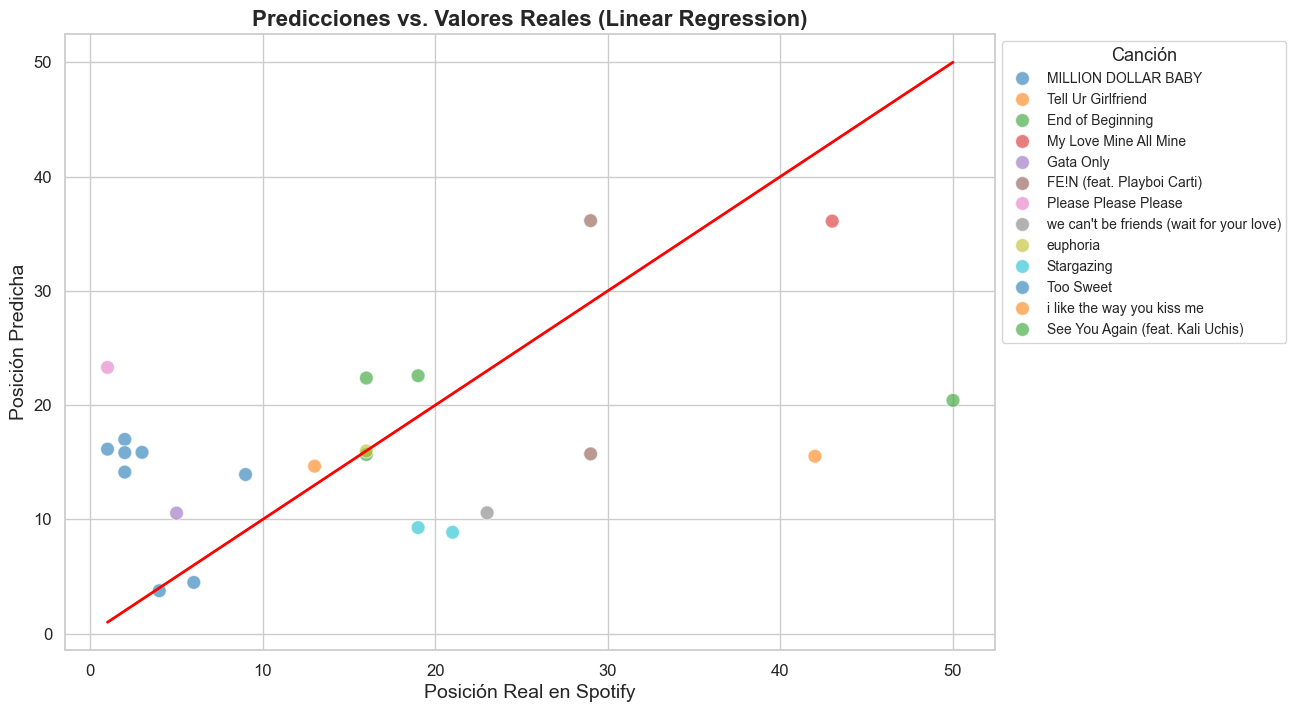

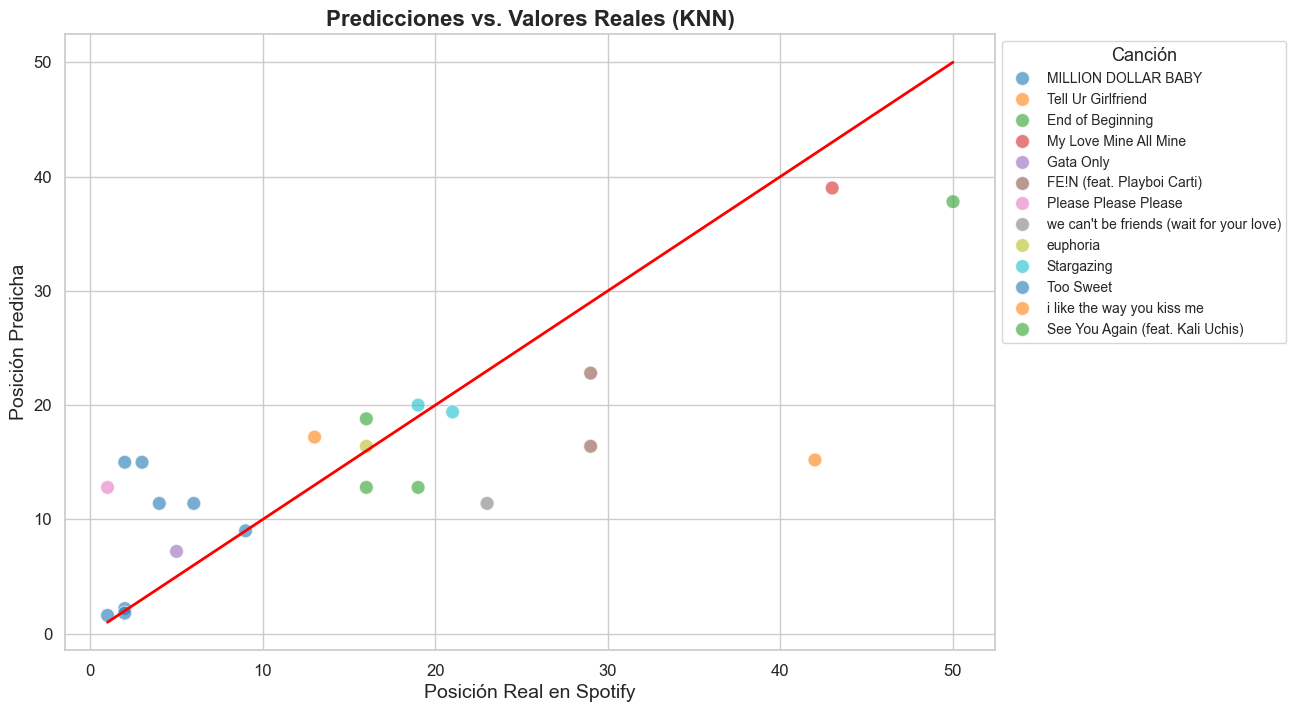

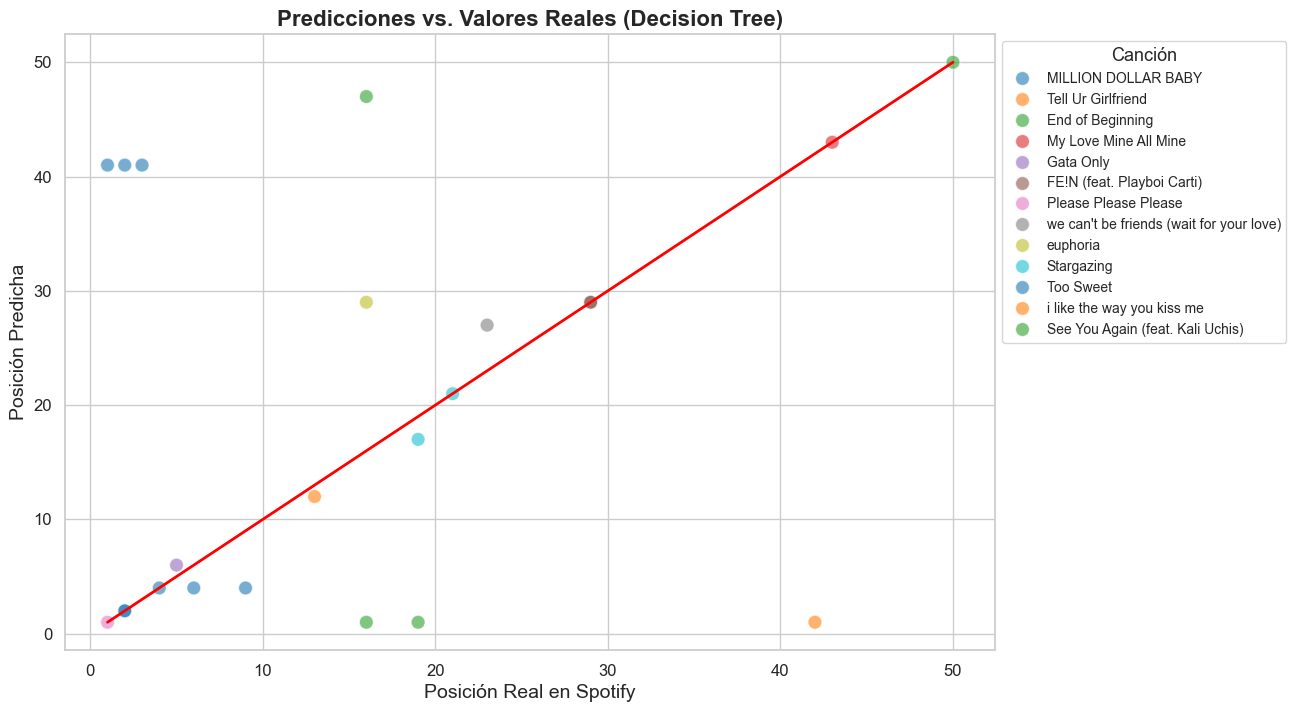

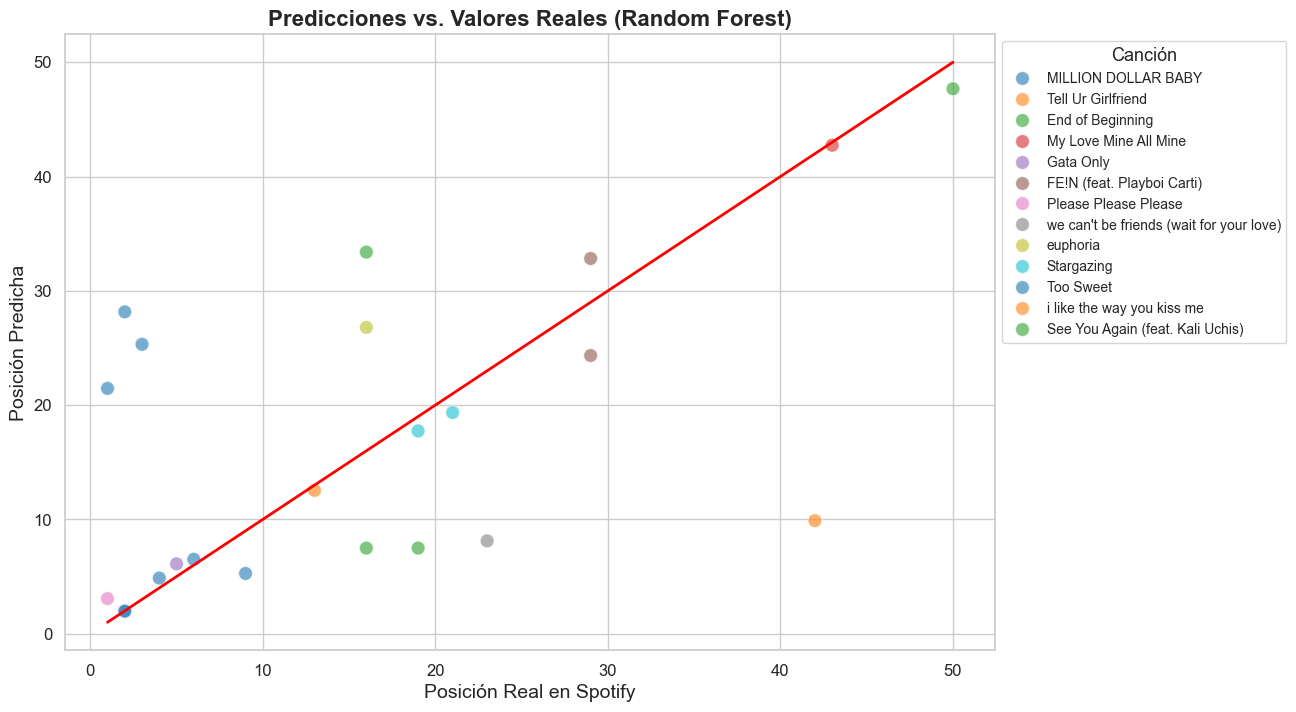

In [19]:
# Función para crear gráficos de dispersión mejorados sin etiquetas
def plot_predictions(y_test, y_pred, title, labels):
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=100, hue=labels, palette='tab10')
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', lw=2, ax=ax)
    ax.set_xlabel('Posición Real en Spotify', fontsize=14)
    ax.set_ylabel('Posición Predicha', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Canción', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title_fontsize='13')
    plt.show()

# Ejemplo de uso con etiquetas de los datos (suponiendo que labels es una serie con los nombres de las canciones)
labels = spotifytiktok_df.loc[X_test.index, 'trackName']

# Visualizar las predicciones vs. los valores reales sin etiquetas
plot_predictions(y_test, y_pred_linear, 'Predicciones vs. Valores Reales (Linear Regression)', labels)
plot_predictions(y_test, y_pred_knn, 'Predicciones vs. Valores Reales (KNN)', labels)
plot_predictions(y_test, y_pred_tree, 'Predicciones vs. Valores Reales (Decision Tree)', labels)
plot_predictions(y_test, y_pred_forest, 'Predicciones vs. Valores Reales (Random Forest)', labels)



Mean Squared Error (Random Forest): 154.10274782608695


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_3740\453734644.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




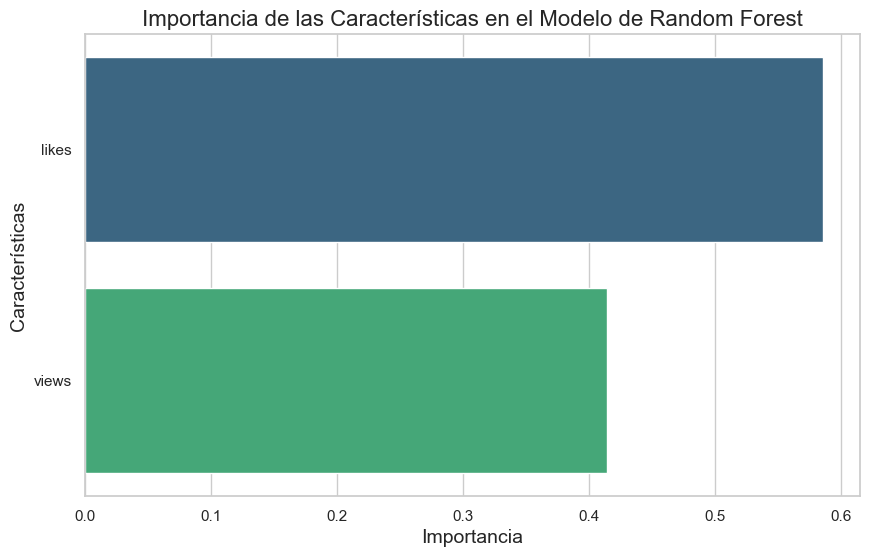

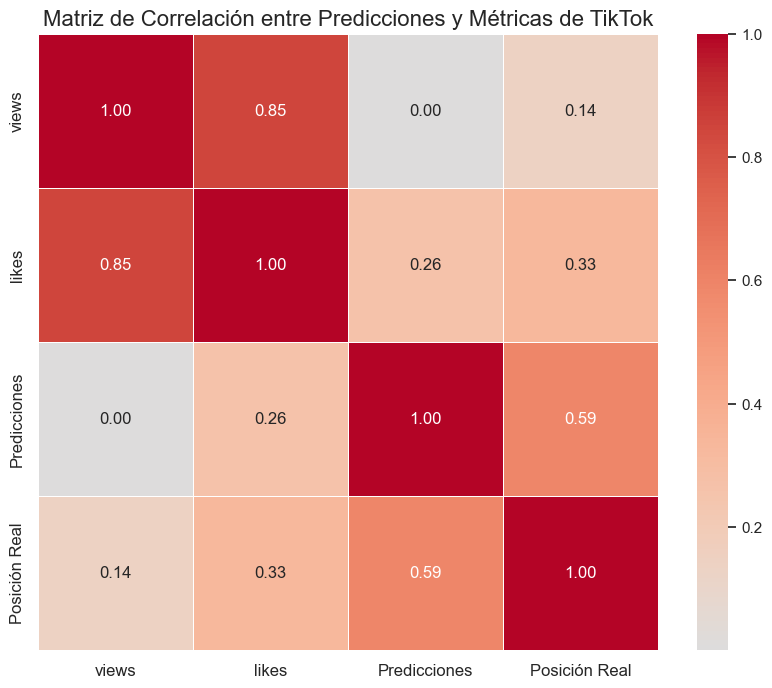

In [20]:
# Entrenar el modelo de random forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_forest = forest_model.predict(X_test)

# Evaluar el modelo
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f'Mean Squared Error (Random Forest): {mse_forest}')

# Interpretar el Modelo
feature_importances = forest_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importancia de las Características en el Modelo de Random Forest', fontsize=16)
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Características', fontsize=14)
plt.show()

# Correlación entre Predicciones y Métricas de TikTok
X_test['Predicciones'] = y_pred_forest
X_test['Posición Real'] = y_test

correlation_matrix = X_test.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title('Matriz de Correlación entre Predicciones y Métricas de TikTok', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()